In [1]:
import os
os.environ["SPS_HOME"] = "/Users/fpetri/packages/fsps" 

In [2]:
import numpy as np
import lbg_forecast.nz as nz
import lbg_forecast.emulator as em
import lbg_forecast.hyperparameters as hyp
import lbg_forecast.population_model as pop
import lbg_forecast.priors as pr
import matplotlib.pyplot as plt
import scipy as sc

In [3]:
# initalise fsps emulator
model = em.fsps_emulator("/Users/fpetri/repos/LBGforecast")

In [4]:
# nz histogram parameters
dz = 0.1
minz = 0.0
maxz = 7.0

bins = np.arange(minz, maxz, dz)

In [5]:
bounds = hyp.hyperparameter_tighter()
nhypersamples = 5
hyperparameter_samples = np.vsplit(hyp.sample_prior_parameters(nhypersamples, bounds[0], bounds[1]), nhypersamples)

In [6]:
prior_data = pr.preload_prior_data(zmax=7.0)

In [7]:
nsamples = 200000
nzs = []
spsp = []
for row in hyperparameter_samples:
    sps_params = pop.generate_sps_parameters(nsamples, row[0], prior_data, uniform_redshift_mass=False, uniform_logf=False)
    lbg_nzs = nz.simulate_nzs(sps_params, model, 1000)
    nzs.append(lbg_nzs)
    spsp.append(sps_params)

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/Users/fpetri/anaconda3/

In [8]:
nzs[0][0][0]

array([3.58025657, 0.14884187, 0.80372502, 2.54388303, 2.14015376,
       0.65217548, 0.27049772, 0.20862625, 0.10638704, 0.10638704,
       0.13651653, 1.88928785, 3.36628874, 2.97335436, 3.16195422,
       1.84830056, 0.27243231, 2.88804035, 2.41801994, 0.16963136,
       1.98416874, 2.88153744, 2.54638234, 2.07698423, 2.93732977,
       3.1902852 , 2.78749774, 2.55132442, 0.92673685, 0.30368734,
       2.78132358, 3.09905404, 0.15006199, 2.87595677, 2.87595677,
       2.7647328 , 0.27022227, 2.90625222, 0.55050524, 0.11995212,
       2.97954918, 2.65745756, 3.12505844, 0.66436928, 3.42099951,
       2.99070973, 3.00270571, 2.86491917, 0.8162522 , 1.98204634,
       2.6393267 , 3.25946629, 2.59468662, 0.08580701, 2.48161838,
       3.12819417, 2.77102218, 3.55638556, 1.05291602, 2.89853359,
       0.11612105, 3.27293509, 2.30453209, 3.06014433, 2.69837866,
       0.83924242, 2.73188093, 3.37795548, 1.32302738, 3.21717727,
       2.79721032, 2.25352298, 3.13908981, 1.95080858, 0.08818

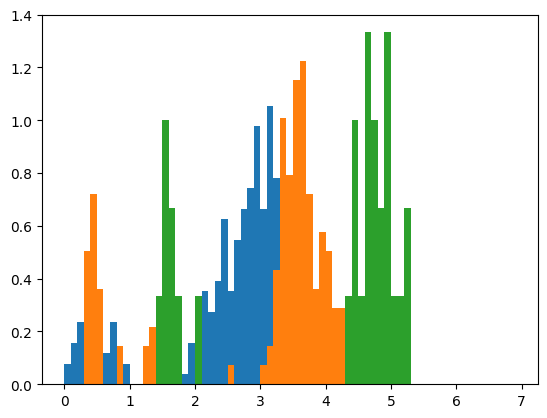

In [15]:
indx = 4
hist = plt.hist(nzs[indx][0][0], density=True, bins=bins)
hist = plt.hist(nzs[indx][1][0], density=True, bins=bins)
hist = plt.hist(nzs[indx][2][0], density=True, bins=bins)

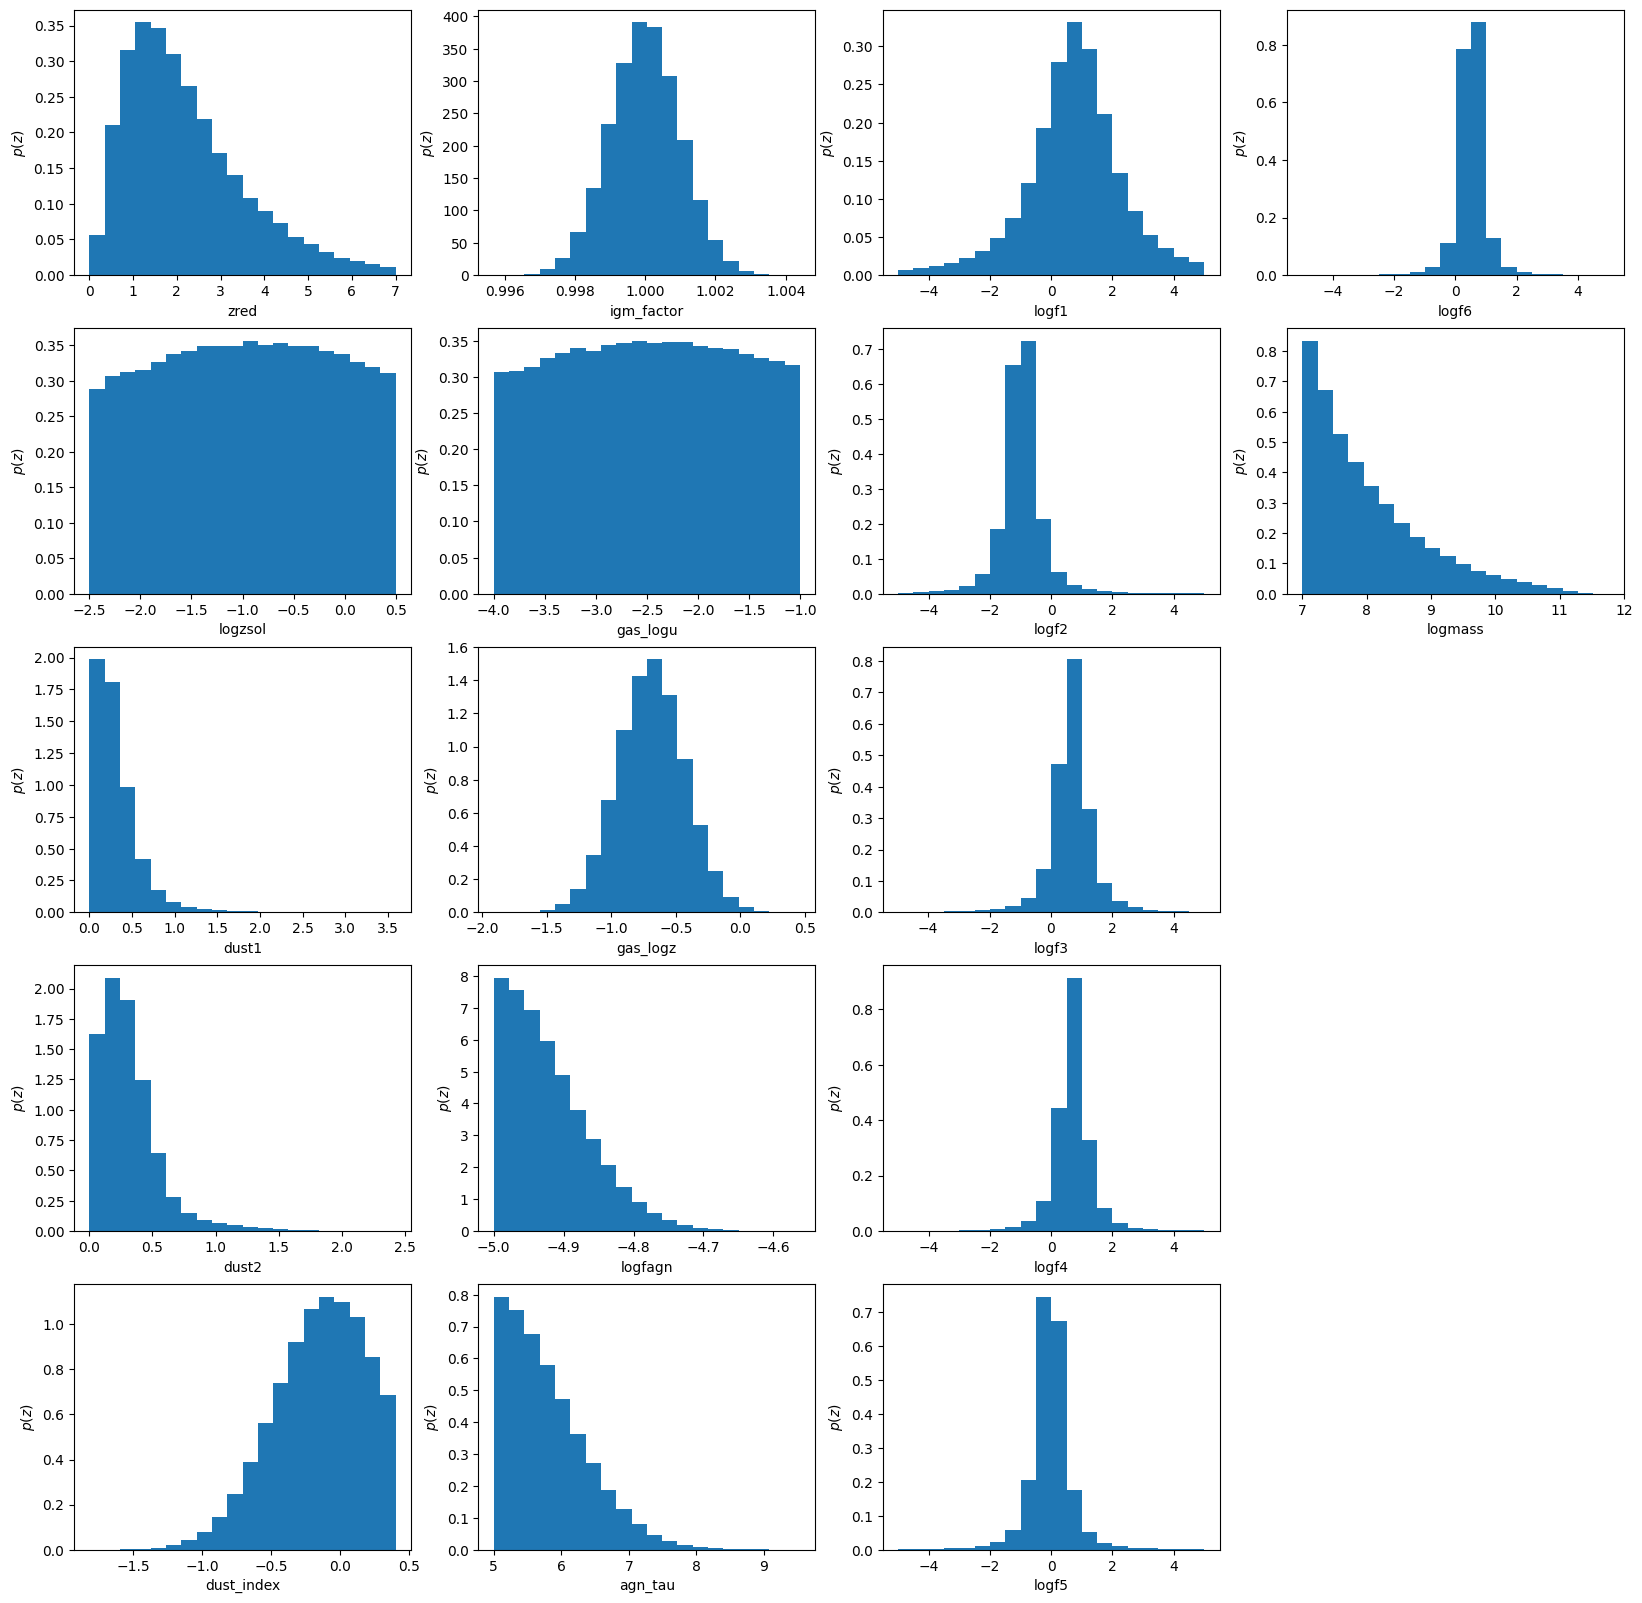

In [16]:
pop.plot_galaxy_population(spsp[indx])

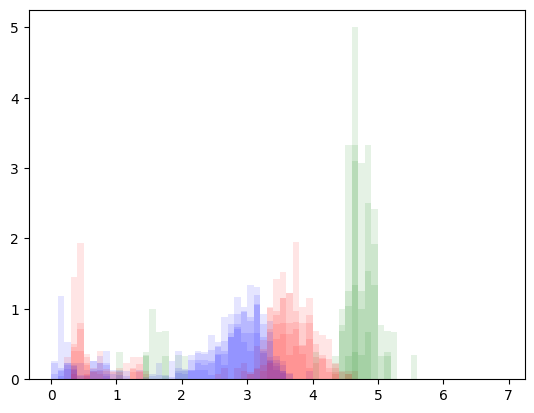

In [17]:
for ind in range(nhypersamples):
    hist = plt.hist(nzs[ind][0][0], density=True, bins=bins, alpha = 0.1, color='blue')
    hist = plt.hist(nzs[ind][1][0], density=True, bins=bins, alpha = 0.1, color='red')
    hist = plt.hist(nzs[ind][2][0], density=True, bins=bins, alpha = 0.1, color='green')

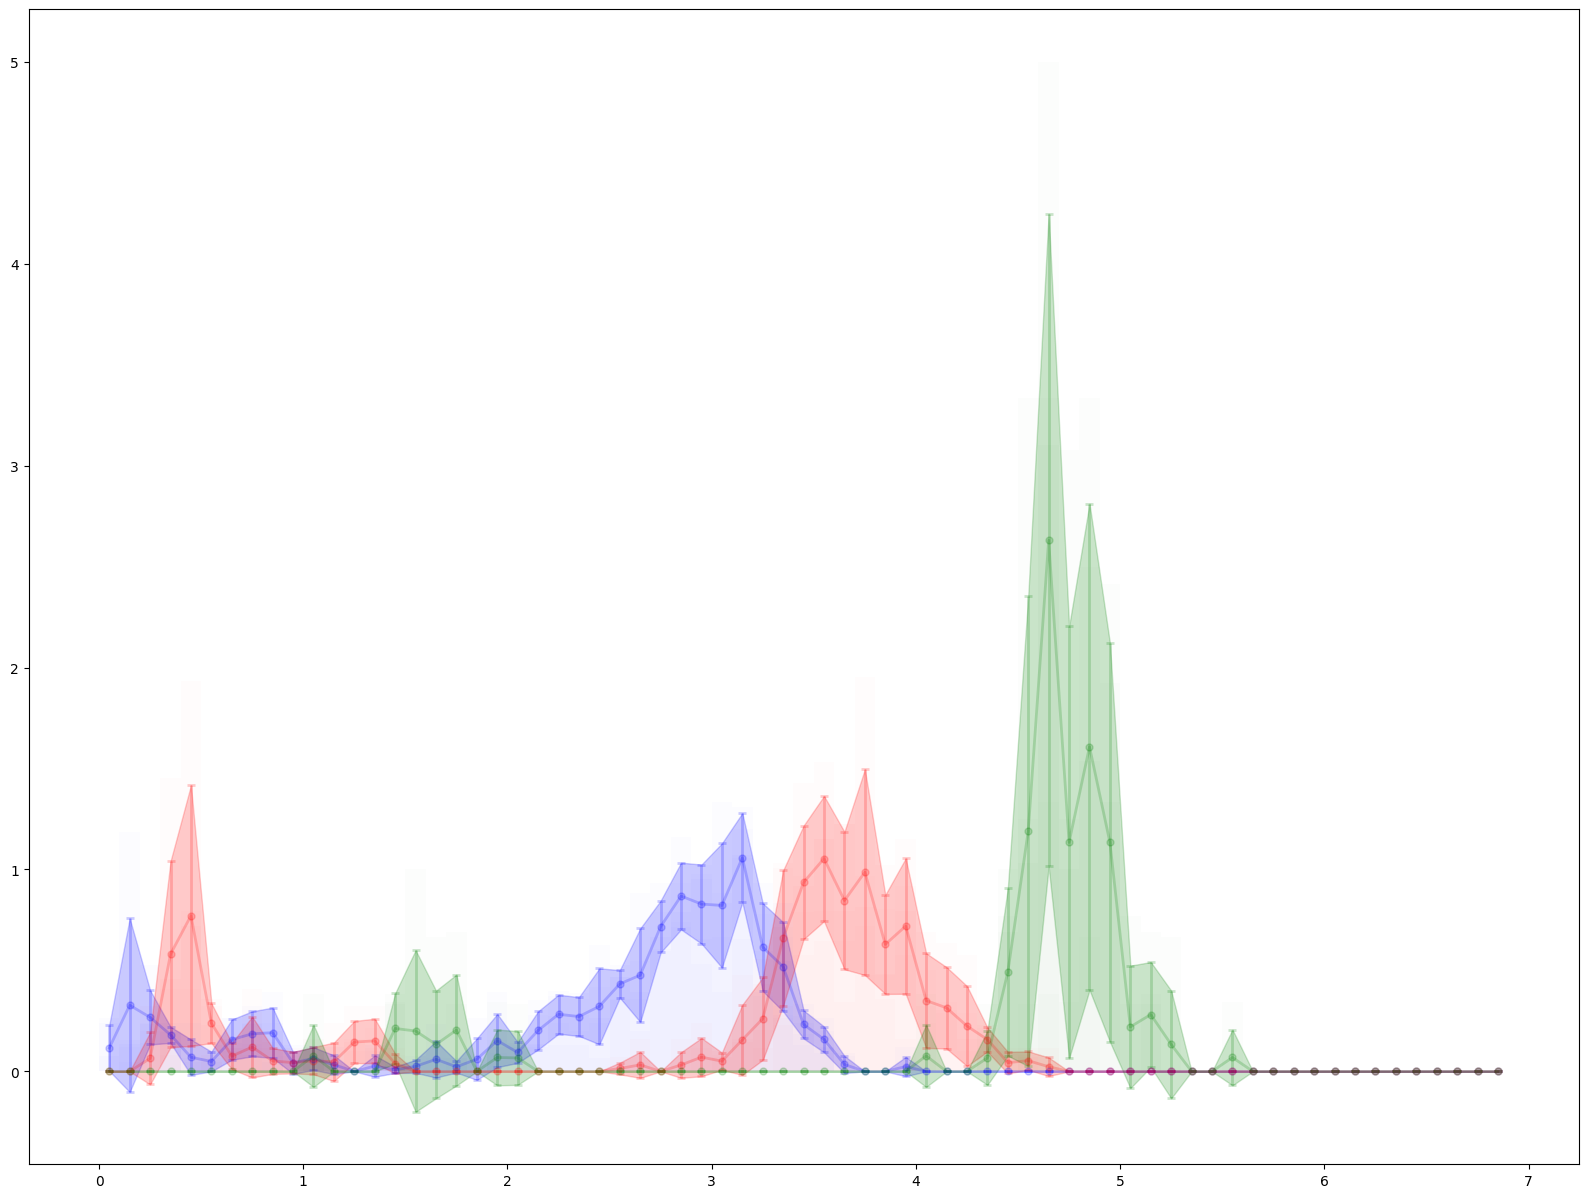

In [18]:
fig1, axes = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

colours = ['blue', 'red', 'green']
for drop in range(3):

    values = []
    x = []
    for ind in range(nhypersamples):
        hist = axes.hist(nzs[ind][drop][0], density=True, bins=bins, alpha = 0.01, color=colours[drop])
        values.append(hist[0])
        x.append(hist[1])

    values = np.hstack((np.array(values)))
    x = np.array(x)
    x = np.hstack(((x+0.05)[:,:-1]))


    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'mean', bins=bins)
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'std', bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes.errorbar(bin_centers, bin_means, bin_std, alpha=0.2, ms=10, marker=".", elinewidth=2, capsize=3, capthick=2, lw=2, color=colours[drop])
    axes.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2, color=colours[drop])

[0.32894736842105265, 0.09767441860465116, 0.17857142857142858, 0.13333333333333333, 0.12109375]
[0.5, 0.15079365079365079, 0.13793103448275862, 0.19387755102040816, 0.20863309352517986]
[0.0, 0.0, 0.07692307692307693, 0.034482758620689655, 0.03333333333333333]


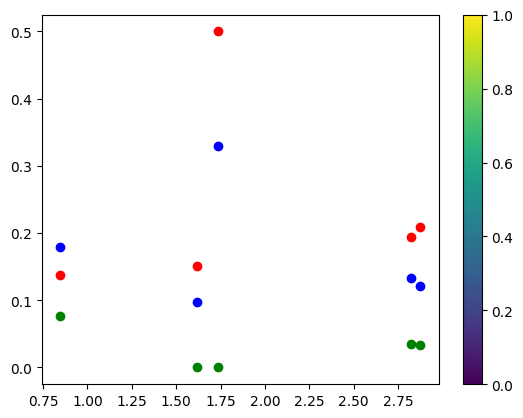

In [19]:
def calculate_interloper_fraction(nz_redshift_samples):

    nint = len(np.where(nz_redshift_samples < 1.5)[0])
    tot = nz_redshift_samples.shape[0]
    return nint/tot

def calculate_highz_fraction(sps_parameter_samples):

    n_high_z = (np.where(sps_parameter_samples[:, 0] > 2.5)[0]).shape[0]
    n_tot = sps_parameter_samples[:, 0].shape[0]

    return n_high_z/n_tot

def calculate_highm_fraction(sps_parameter_samples):
    
    n_high_m = (np.where(sps_parameter_samples[:, -1] > 10**9)[0]).shape[0]
    n_tot = sps_parameter_samples[:, -1].shape[0]

    return n_high_m/n_tot

interloper_fractions = []
hyperparameters = []
highz_fracs = []
highm_fracs = []

ndropouts = 3
colours = ['blue', 'red', 'green']
for dropout in range(ndropouts):
    hyperparameters = []
    interloper_fractions = []
    highz_fracs = []
    highm_fracs = []
    for index in range(nhypersamples):
        interloper_fractions.append(calculate_interloper_fraction(nzs[index][dropout][0]))
        hyperparameters.append(hyperparameter_samples[index][0][11])# 6, 7, 10, 19  sus?
        highz_fracs.append(calculate_highz_fraction(spsp[index]))
        highm_fracs.append(calculate_highm_fraction(spsp[index]))
    plt.scatter(hyperparameters, interloper_fractions, color=colours[dropout])
    #plt.scatter(highm_fracs, highz_fracs, c=interloper_fractions, cmap='Reds')
    print(interloper_fractions)
plt.colorbar()


In [ ]:
#np.save("nzs_test.npy", nzs)
#np.save("spsp_test.npy", spsp)